In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os

# Character database exploration

## Load database

In [2]:
PATH = os.getcwd()
PATH = os.path.join(PATH, 'data', 'character.metadata.tsv')

header_character = ['wikipedia_id',
                    'freebase_id',
                    'release_date',
                    'character_name',
                    'actor_birth',
                    'actor_gender',
                    'actor_height',
                    'freebase_actor_ethnicity',
                    'actor_name',
                    'actor_age_at_release',
                    'Freebase character/actor map ID',
                    'freebase_character_id',
                    'freebase_actor_id']

df_character = pd.read_csv(PATH, sep='\t', header=None)
df_character.columns = header_character

## First look at the data

### Descriptive statistics

In [3]:
df_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   wikipedia_id                     450669 non-null  int64  
 1   freebase_id                      450669 non-null  object 
 2   release_date                     440674 non-null  object 
 3   character_name                   192794 non-null  object 
 4   actor_birth                      344524 non-null  object 
 5   actor_gender                     405060 non-null  object 
 6   actor_height                     154824 non-null  float64
 7   freebase_actor_ethnicity         106058 non-null  object 
 8   actor_name                       449441 non-null  object 
 9   actor_age_at_release             292556 non-null  float64
 10  Freebase character/actor map ID  450669 non-null  object 
 11  freebase_character_id            192804 non-null  object 
 12  fr

In [4]:
df_character['release_date'].sample(10)

140542    1941-07-11
297652          1978
130550    1974-03-27
370545    1926-07-18
445203    2012-02-17
137615    2010-09-15
362021    1933-02-23
417898    2009-12-03
7381      2005-11-25
445472          1942
Name: release_date, dtype: object

Inspecting with the info method allows to see that the columns 'release_date' and 'actor_birth' are 'object' type. We will have to convert them to datetime type to be able to use them more efficiently. If the conversion is done directly, lots of the data will be lost. We first have standardize the format of the dates to ensure the ````pd.to_datetime()```` method will work properly. A naive approach led to more than 40% of data lost.

In [5]:
print(f'Before the conversion, the number of missing release dates is {df_character["release_date"].isna().sum()}.\n')
print(f'Before the conversion, the number of missing actor birth dates is {df_character["actor_birth"].isna().sum()}.\n')

Before the conversion, the number of missing release dates is 9995.

Before the conversion, the number of missing actor birth dates is 106145.



In [6]:
# Convert to datetime using the ISO8601 format
df_character['release_date'] = pd.to_datetime(df_character['release_date'], errors='coerce', format='ISO8601')
df_character['actor_birth'] = pd.to_datetime(df_character['actor_birth'], errors='coerce')

In [7]:
print(f'After the conversion, the number of missing dates is {df_character["release_date"].isna().sum()}.\n')
print(f'After the conversion, the number of missing actor birth dates is {df_character["actor_birth"].isna().sum()}.\n')

df_character["actor_birth"]

After the conversion, the number of missing dates is 10010.

After the conversion, the number of missing actor birth dates is 120782.



0        1958-08-26
1        1974-08-15
2        1969-06-15
3        1967-09-12
4        1977-09-25
            ...    
450664          NaT
450665   1965-04-12
450666   1941-11-18
450667          NaT
450668          NaT
Name: actor_birth, Length: 450669, dtype: datetime64[ns]

It seems like the conversion went well since we haven't lost much more data during the conversion process. Datetime columns should now be usable.

Plotting 'release_date' and 'actor_birth' distributions.

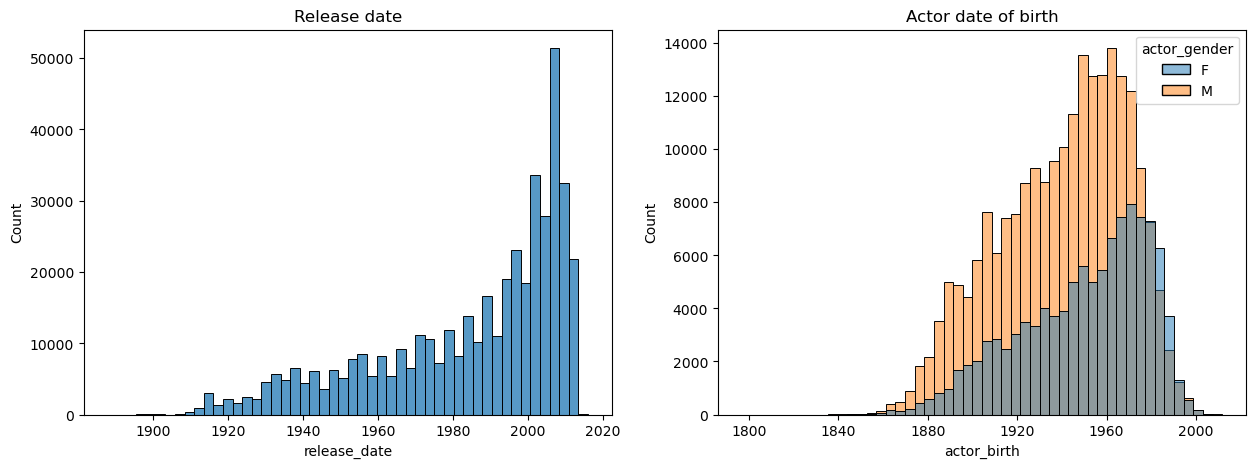

In [8]:
# Plotting 'release_date' and 'actor_birth' distributions.
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df_character['release_date'].dropna().dt.year,bins=50, ax=ax[0])
sns.histplot(data=df_character, x='actor_birth', hue='actor_gender', bins=50, ax=ax[1])
ax[0].set_title('Release date')
ax[1].set_title('Actor date of birth')
plt.show()


In [9]:
df_character.describe(include=['object', 'datetime','float64'])

,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,freebase_actor_ethnicity,actor_name,actor_age_at_release,Freebase character/actor map ID,freebase_character_id,freebase_actor_id
count,450669,440659,192794,329887,405060,154824.000000,106058,449441,292556.000000,450669,192804,449854
unique,64330,NaN,126629,NaN,2,NaN,479,134078,NaN,450669,183435,135760
top,/m/0cc8620,NaN,Doctor,NaN,M,NaN,/m/0dryh9k,Mel Blanc,NaN,/m/0bgchxw,/m/0h577m2,/m/0c5vh
freq,115,NaN,198,NaN,270257,NaN,16351,791,NaN,1,146,791
mean,NaN,1984-11-10 22:25:30.832684736,NaN,1943-05-29 11:41:52.427588992,NaN,1.788893,NaN,NaN,37.788523,NaN,NaN,NaN
min,NaN,1888-01-01 00:00:00,NaN,1796-09-20 00:00:00,NaN,0.610000,NaN,NaN,-7896.000000,NaN,NaN,NaN
25%,NaN,1969-01-01 00:00:00,NaN,1922-09-01 00:00:00,NaN,1.676400,NaN,NaN,28.000000,NaN,NaN,NaN
50%,NaN,1994-01-01 00:00:00,NaN,1948-02-25 00:00:00,NaN,1.750000,NaN,NaN,36.000000,NaN,NaN,NaN
75%,NaN,2005-08-20 00:00:00,NaN,1966-07-11 00:00:00,NaN,1.830000,NaN,NaN,47.000000,NaN,NaN,NaN
max,NaN,2016-06-08 00:00:00,NaN,2011-09-02 00:00:00,NaN,510.000000,NaN,NaN,103.000000,NaN,NaN,NaN


### Missing values

In [10]:
df_character.isnull().mean() * 100

wikipedia_id                        0.000000
freebase_id                         0.000000
release_date                        2.221142
character_name                     57.220488
actor_birth                        26.800601
actor_gender                       10.120288
actor_height                       65.645740
freebase_actor_ethnicity           76.466542
actor_name                          0.272484
actor_age_at_release               35.084064
Freebase character/actor map ID     0.000000
freebase_character_id              57.218269
freebase_actor_id                   0.180842
dtype: float64

We can observe that some columns do have a lot of missing values. If we want to use these columns, we will have to find a way to deal with it, either by dropping them or completing them with external sources.

In [11]:
df_character.describe(include='all')

,wikipedia_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,freebase_actor_ethnicity,actor_name,actor_age_at_release,Freebase character/actor map ID,freebase_character_id,freebase_actor_id
count,4.506690e+05,450669,440659,192794,329887,405060,154824.000000,106058,449441,292556.000000,450669,192804,449854
unique,NaN,64330,NaN,126629,NaN,2,NaN,479,134078,NaN,450669,183435,135760
top,NaN,/m/0cc8620,NaN,Doctor,NaN,M,NaN,/m/0dryh9k,Mel Blanc,NaN,/m/0bgchxw,/m/0h577m2,/m/0c5vh
freq,NaN,115,NaN,198,NaN,270257,NaN,16351,791,NaN,1,146,791
mean,1.396975e+07,NaN,1984-11-10 22:25:30.832684736,NaN,1943-05-29 11:41:52.427588992,NaN,1.788893,NaN,NaN,37.788523,NaN,NaN,NaN
min,3.300000e+02,NaN,1888-01-01 00:00:00,NaN,1796-09-20 00:00:00,NaN,0.610000,NaN,NaN,-7896.000000,NaN,NaN,NaN
25%,3.759292e+06,NaN,1969-01-01 00:00:00,NaN,1922-09-01 00:00:00,NaN,1.676400,NaN,NaN,28.000000,NaN,NaN,NaN
50%,1.189065e+07,NaN,1994-01-01 00:00:00,NaN,1948-02-25 00:00:00,NaN,1.750000,NaN,NaN,36.000000,NaN,NaN,NaN
75%,2.366501e+07,NaN,2005-08-20 00:00:00,NaN,1966-07-11 00:00:00,NaN,1.830000,NaN,NaN,47.000000,NaN,NaN,NaN
max,3.750192e+07,NaN,2016-06-08 00:00:00,NaN,2011-09-02 00:00:00,NaN,510.000000,NaN,NaN,103.000000,NaN,NaN,NaN


Inspecting the description is very insightful for numerical data. For instance, we can see that the minimum age at release is negative (-7896), which might indicate that something went wrong at some point. 

Same goes for the maximum height, who's 510 meters. The minimum height is suspiciously small too (0.61 m), but could be consistent with a baby actor for instance. 

Lastly, the minimum actor birth date is 1796-09-20, which can be consistent with the first movies ever made but still seems a bit unlikely.

## Checking age at release

### Plotting the data

It is expected to see the distribution looking weird with an outlier at -7896 years old. Plotting the distribution could give us more insights.

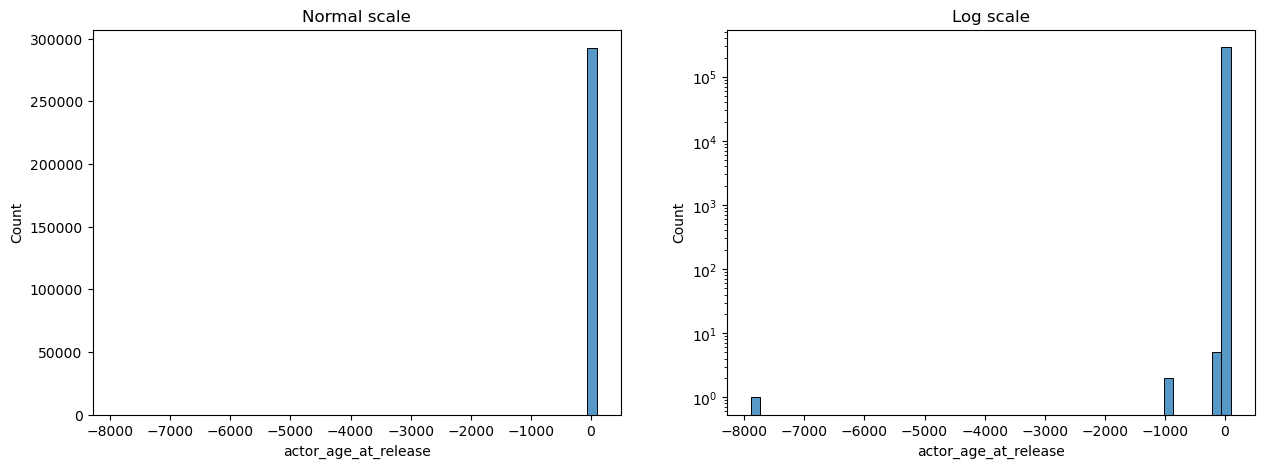

In [12]:
# Plotting 'actor_age_at_release' distribution in normal and log scale
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_character, x='actor_age_at_release', bins=50, ax=ax[0])
sns.histplot(data=df_character, x='actor_age_at_release', bins=50, log_scale=[False,True], ax=ax[1])
ax[0].set_title('Normal scale')
ax[1].set_title('Log scale')
plt.show()

This plot reveals other negative ages aswell. Replotting the distribution without the negative ages should reveal a more realistic distribution.

### Cleaning the data

In [109]:
# Removing negative ages
df_character = df_character[df_character['actor_age_at_release'] > 0]

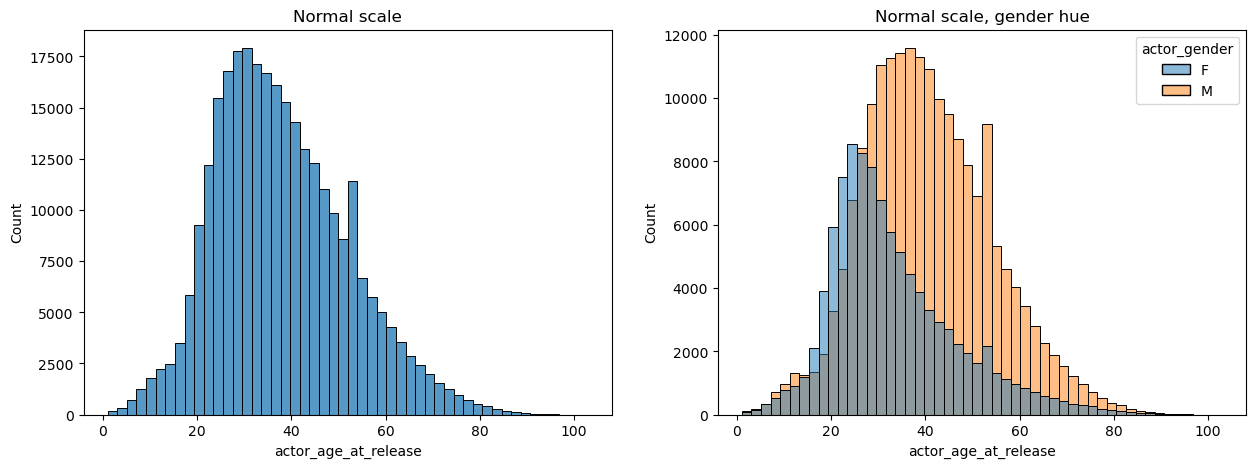

In [110]:
# Plot cleaned age at release
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df_character, x='actor_age_at_release', bins=50, ax=ax[0])
sns.histplot(data=df_character, x='actor_age_at_release',hue='actor_gender', bins=50, ax=ax[1])
ax[0].set_title('Normal scale')
ax[1].set_title('Normal scale, gender hue')
plt.show()

In [117]:
df_character['actor_age_at_release'].describe()
df_character[df_character['actor_age_at_release'] == 103]

,wikipedia_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,freebase_actor_ethnicity,actor_name,actor_age_at_release,Freebase character/actor map ID,freebase_character_id,freebase_actor_id
230088,30241563,/m/0g59rl8,2004-01-01,NaN,1900-12-20,M,NaN,NaN,Lokesh,103.0,/m/0jx7c12,NaN,/m/0bbz0rv
407572,34362803,/m/0h_chfy,2012-03-06,NaN,1908-05-30,M,NaN,/m/041rx,Mel Blanc,103.0,/m/0mzkr96,NaN,/m/0c5vh


Checking for the oldest age at release reveals Mel Blanc, a famous voice actor who died in 1989. Further inspection reveals that indeed, his voice recording were used in a movie released in 2012, which would explain the very old age at release. However, we will have to drop this row since it is not relevant. The actor 'Lokesh' is a bit more mysterious since a simple name is not sufficient to trace back to him. We will drop this row aswell.

## Checking actor height

### Plotting the data

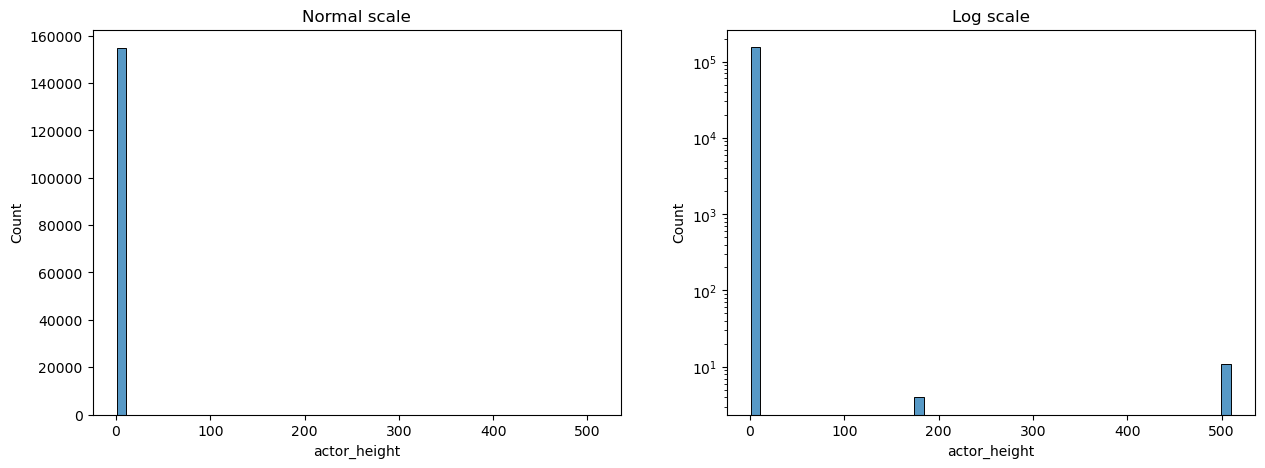

In [29]:
# Plotting 'actor_height' distribution in normal and log scale
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_character, x='actor_height', bins=50, ax=ax[0])
sns.histplot(data=df_character, x='actor_height', bins=50, log_scale=[False,True], ax=ax[1])
ax[0].set_title('Normal scale')
ax[1].set_title('Log scale')
plt.show()

In [52]:
display(df_character.loc[df_character['actor_height'] > 2.5])
display(df_character['actor_name'].loc[df_character['actor_height'] > 2.5].unique())

,wikipedia_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,freebase_actor_ethnicity,actor_name,actor_age_at_release,Freebase character/actor map ID,freebase_character_id,freebase_actor_id
21619,1291587,/m/04qk12,2004-09-01,young Georgie,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,18.0,/m/0k276dx,/m/0k276dz,/m/0bggwvl
49659,30865068,/m/02ml14,1998-10-15,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0n9ld0y,NaN,/m/08hqh0
59719,12206655,/m/02vvw24,NaT,Dominic,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,NaN,/m/0k276dq,/m/0h8hcr1,/m/0bggwvl
104140,17999628,/m/047n_2q,1998-01-01,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0cg31bd,NaN,/m/08hqh0
205679,1373475,/m/04xmx8,2003-08-15,Jackal Johnson,1972-12-06,M,510.0,NaN,Vince Corazza,30.0,/m/02vbm0k,/m/0h60xk7,/m/08hqh0
219383,179326,/m/018gq3,1996-11-18,Herbert,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,10.0,/m/0bggwv8,/m/0bggwvc,/m/0bggwvl
301653,4667507,/m/0cg9n6,2001-11-29,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,28.0,/m/0cg0zwp,NaN,/m/08hqh0
316621,3915041,/m/0b6lyp,2002-01-01,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,29.0,/m/02vc5p5,NaN,/m/08hqh0
341890,29290087,/m/0b3w9mr,1997-04-07,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,24.0,/m/0gvwy8x,NaN,/m/08hqh0
360967,14413223,/m/03d2rnl,2012-04-20,Young Punk Guy,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,26.0,/m/0m4q87d,/m/0k9tfs8,/m/0bggwvl


array(['Zohren Weiss', 'Vince Corazza', 'Benedict Smith'], dtype=object)

We can see that 3 actors have weird height. Looking at the data, it can be expected that 510m are in fact 5ft10 (1.78 m), and 180 m are in fact 180 cm. We can correct those data manually since there are only 3 of them. The actual values taken are those found in a quick Google search.

### Correcting the data

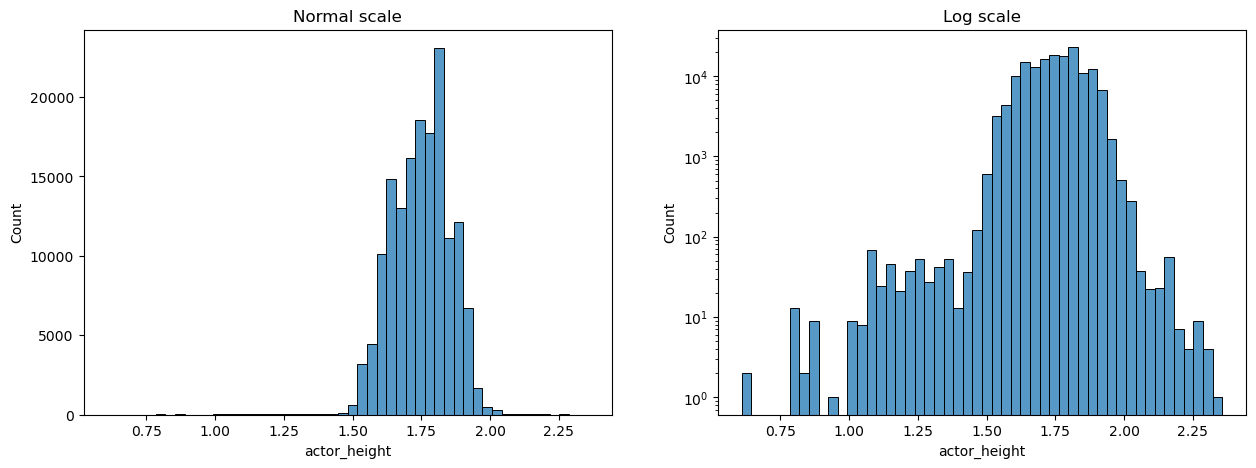

In [53]:
# Correct the height of the actor
df_character.loc[df_character['actor_name'] == 'Zohren Weiss', 'actor_height'] = 1.78
df_character.loc[df_character['actor_name'] == 'Vince Corazza', 'actor_height'] = 1.78
df_character.loc[df_character['actor_name'] == 'Benedict Smith', 'actor_height'] = 1.8

# Plotting corrected 'actor_height' distribution in normal and log scale
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_character, x='actor_height', bins=50, ax=ax[0])
sns.histplot(data=df_character, x='actor_height', bins=50, log_scale=[False,True], ax=ax[1])
ax[0].set_title('Normal scale')
ax[1].set_title('Log scale')
plt.show()

It seems that some actors have very small height. While still possible, a quick check could give us some insights.

In [107]:
display(df_character['actor_name'].loc[df_character['actor_height'] < 1].unique())
display(df_character.loc[df_character['actor_height'] < 1].head(10))

array(['Verne Troyer', 'Angelo Rossitto', 'Weng Weng',
       'Ian Michael Smith', 'Kara Hoffman', 'Shelby Hoffman'],
      dtype=object)

,wikipedia_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,freebase_actor_ethnicity,actor_name,actor_age_at_release,Freebase character/actor map ID,freebase_character_id,freebase_actor_id
8930,11894802,/m/02rx3lg,2002-02-15,NaN,1969-01-01,M,0.813,/m/02ctzb,Verne Troyer,33.0,/m/0cg51dp,NaN,/m/02624t
20169,27913339,/m/04j2r04,1972-01-01,NaN,1908-02-18,M,0.880,NaN,Angelo Rossitto,63.0,/m/0gc8klk,NaN,/m/03cpdhs
24352,19702661,/m/04myqw6,1978-01-01,NaN,1908-02-18,M,0.880,NaN,Angelo Rossitto,69.0,/m/0gxks0g,NaN,/m/03cpdhs
31433,13848388,/m/03cl4dn,1982-01-01,Secret Agent 00,1957-09-07,M,0.830,NaN,Weng Weng,24.0,/m/02dj7c3,/m/02nwpfg,/m/09bn8v
69652,241603,/m/01k1k4,1999-06-08,Mini-Me,1969-01-01,M,0.813,/m/02ctzb,Verne Troyer,30.0,/m/03jpfxd,/m/03z6_2,/m/02624t
89477,11893608,/m/02rx2hc,1996-01-01,NaN,1969-01-01,M,0.813,/m/02ctzb,Verne Troyer,26.0,/m/03jrf_8,NaN,/m/02624t
98757,21117005,/m/05c31_f,1970-05-01,Seymour spider,1908-02-18,M,0.880,NaN,Angelo Rossitto,NaN,/m/0hp5lr7,/m/0hp5lrb,/m/03cpdhs
98758,21117005,/m/05c31_f,1970-05-01,Clang,1908-02-18,M,0.880,NaN,Angelo Rossitto,NaN,/m/0hp5ls7,/m/0hp5lsb,/m/03cpdhs
110997,4562945,/m/0c911r,2007-10-12,NaN,1969-01-01,M,0.813,/m/02ctzb,Verne Troyer,38.0,/m/03jp86v,NaN,/m/02624t
122863,2281450,/m/070m8v,1998-09-11,Simon Birch,1987-05-05,M,0.940,NaN,Ian Michael Smith,11.0,/m/0k39m5,/m/0gwwcp6,/m/0cp8vl


Since the number of actors with small height is small, a manual inspection can be performed. It seems that the heights are correct, and that the actors are indeed small, except for the twins Kara and Shelby Hoffman who were 2 years old at the film release.

## Checking release dates

### Plotting the data

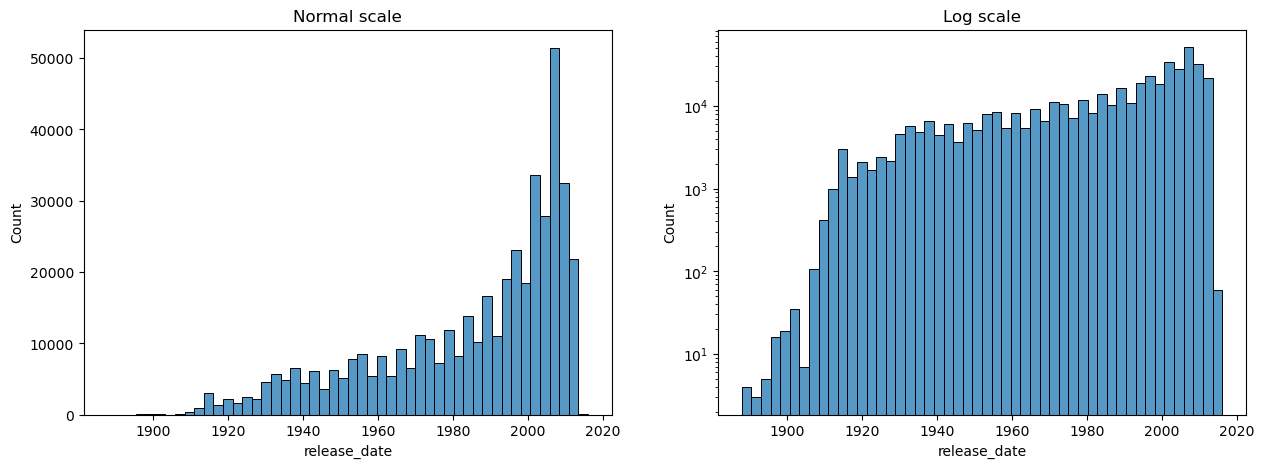

In [68]:
# Plotting 'release_date' distribution in normal and log scale
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_character, x=df_character['release_date'].dt.year, bins=50, ax=ax[0])
sns.histplot(data=df_character, x=df_character['release_date'].dt.year, bins=50, log_scale=[False,True], ax=ax[1])
ax[0].set_title('Normal scale')
ax[1].set_title('Log scale')
plt.show()

In [69]:
df_character['release_date'].describe()

count                           440659
mean     1984-11-10 22:25:30.832684736
min                1888-01-01 00:00:00
25%                1969-01-01 00:00:00
50%                1994-01-01 00:00:00
75%                2005-08-20 00:00:00
max                2016-06-08 00:00:00
Name: release_date, dtype: object

A quick overview of the release dates looks like a plausible distribution. However, recalling that the dataset was made in 2012, it's odd noticing the max release date is 2016. Assuming that the film of 2013 could have been annonced, let's check the number of films released starting from 2014.

In [88]:
print(f'Number of film released in 2013: {df_character[df_character.release_date > "2013-01-01"].shape[0]}.\n')
print(f'Number of film released in 2014: {df_character[df_character.release_date > "2014-01-01"].shape[0]}.\n')

Number of film released in 2013: 740.

Number of film released in 2014: 48.



### Correcting the data

 ## Checking for duplicates

In [73]:
df_character.duplicated().sum()

0

There is no naively duplicate rows, which is good news so far. However, it is possible that some rows could be duplicates on specific subset of columns. The critical values to check are the character ID and the actor ID in a given movie.

In [124]:
# Check for duplicates
duplicates = df_character.duplicated(subset=['wikipedia_id', 'freebase_actor_id'], keep=False)
display(df_character[duplicates])

print(f'There is {duplicates.sum()} duplicates rows in the subset')
print(f'NA in the subset:\n{df_character[duplicates].isna().sum()}\n')

,wikipedia_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,freebase_actor_ethnicity,actor_name,actor_age_at_release,Freebase character/actor map ID,freebase_character_id,freebase_actor_id
165,29528534,/m/04j0lfk,1986-01-01,Dr. Pramila,1955-10-17,F,NaN,/m/0cqgdq,Smita Patil,30.0,/m/04j0lfm,/m/0h4_vjt,/m/07hpqm
171,29528534,/m/04j0lfk,1986-01-01,Dr. Pramila,1955-10-17,F,NaN,/m/0cqgdq,Smita Patil,30.0,/m/0dwcl73,/m/0h4_vbv,/m/07hpqm
487,24863901,/m/09gnwkp,2010-01-01,Actress,1976-02-26,F,1.68,/m/04gfy7,Namrata Singh Gujral,33.0,/m/09j46w3,/m/0h6z18c,/m/06n7sx
493,24863901,/m/09gnwkp,2010-01-01,Breast Cancer Survivor,1976-02-26,F,1.68,/m/04gfy7,Namrata Singh Gujral,33.0,/m/0h8248x,/m/0h8248_,/m/06n7sx
901,362719,/m/01_mdl,1978-12-10,Clark Kent,1952-09-25,M,1.93,NaN,Christopher Reeve,26.0,/m/0hd9fl8,/m/02362,/m/0jrny
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450434,454812,/m/02bjfb,1971-08-03,Charles Collins,1941-02-05,M,1.90,NaN,David Selby,30.0,/m/0h_6h3r,/m/0h_6h3v,/m/04pvw3
450657,913762,/m/03pcrp,1992-05-21,Maj. Nexx,1960-04-28,M,NaN,NaN,Steven Blum,32.0,/m/0kr40d9,/m/0kr40df,/m/044_7j
450658,913762,/m/03pcrp,1992-05-21,Lord Feff,1960-04-28,M,NaN,NaN,Steven Blum,32.0,/m/0kr408g,/m/0kr408l,/m/044_7j
450660,913762,/m/03pcrp,1992-05-21,Additional Voices,NaT,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr405f,/m/0kr405k,/m/0gn4bz


There is 4839 duplicates rows in the subset
NA in the subset:
wikipedia_id                          0
freebase_id                           0
release_date                          0
character_name                       45
actor_birth                          99
actor_gender                          2
actor_height                       1941
freebase_actor_ethnicity           2418
actor_name                            0
actor_age_at_release                  0
Freebase character/actor map ID       0
freebase_character_id                44
freebase_actor_id                     0
dtype: int64



In [113]:
df_character[duplicates].describe(include='all')

,wikipedia_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,freebase_actor_ethnicity,actor_name,actor_age_at_release,Freebase character/actor map ID,freebase_character_id,freebase_actor_id
count,1.400000e+01,14,14,8,14,14,6.00000,1,14,14.000000,14,8,14
unique,NaN,12,NaN,7,NaN,2,NaN,1,14,NaN,14,7,14
top,NaN,/m/09pgd4h,NaN,Chorine,NaN,M,NaN,/m/02sch9,Jean Marais,NaN,/m/0lyg3k_,/m/0hz25jm,/m/01vgxq
freq,NaN,3,NaN,2,NaN,8,NaN,1,1,NaN,1,2,1
mean,1.964126e+07,NaN,1970-03-19 01:42:51.428571429,NaN,1937-09-22 10:17:08.571428608,NaN,1.70250,NaN,NaN,32.071429,NaN,NaN,NaN
min,2.422489e+06,NaN,1930-08-30 00:00:00,NaN,1902-03-12 00:00:00,NaN,1.55000,NaN,NaN,19.000000,NaN,NaN,NaN
25%,8.413932e+06,NaN,1939-07-29 00:00:00,NaN,1912-03-04 12:00:00,NaN,1.57750,NaN,NaN,21.750000,NaN,NaN,NaN
50%,2.275107e+07,NaN,1972-03-19 12:00:00,NaN,1930-01-30 12:00:00,NaN,1.63500,NaN,NaN,30.500000,NaN,NaN,NaN
75%,2.955592e+07,NaN,1992-08-12 12:00:00,NaN,1961-01-28 00:00:00,NaN,1.83875,NaN,NaN,38.500000,NaN,NaN,NaN
max,3.359348e+07,NaN,2011-11-17 00:00:00,NaN,1980-09-21 00:00:00,NaN,1.93000,NaN,NaN,51.000000,NaN,NaN,NaN


It can be seen that most of the duplicates rows are due to the fact that most of them are NaN, meaning that there is no data outside of the character ID and the actor ID in the movie : we have no data on that actor ! 

# Playing with IMDb and Metacritic data

## Loading the data

In [17]:
top1000_imdb_movies = pd.read_csv("data/scrap/top1000_IMDB_movies.csv")
cmu_movies = pd.read_csv('data/cmu_movies.csv', sep='\t')
metacritic_reviews = pd.read_csv('data/scrap/metacritic_reviews.csv')

## First look at the data

### Descriptive statistics

In [89]:
display(top1000_imdb_movies.info())
display(cmu_movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdb_id            1000 non-null   object 
 1   title              1000 non-null   object 
 2   year               1000 non-null   int64  
 3   duration           1000 non-null   object 
 4   genres             1000 non-null   object 
 5   number_of_ratings  1000 non-null   int64  
 6   rating             1000 non-null   float64
 7   director           1000 non-null   object 
 8   description        1000 non-null   object 
 9   freebase_id        882 non-null    object 
 10  metacritic_id      799 non-null    object 
 11  metascore          845 non-null    float64
dtypes: float64(2), int64(2), object(8)
memory usage: 93.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wikipedia_id   81741 non-null  int64  
 1   freebase_id    81741 non-null  object 
 2   title          81741 non-null  object 
 3   release_date   74839 non-null  object 
 4   revenue        8401 non-null   float64
 5   runtime        61291 non-null  float64
 6   languages      81741 non-null  object 
 7   countries      81741 non-null  object 
 8   genres         81741 non-null  object 
 9   imdb_id        73497 non-null  object 
 10  metacritic_id  8550 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 6.9+ MB


None

A first overview shows that approximately 800/1000 films have a Metacritic score. 

In [104]:
top1000_imdb_movies['year'].sample(10)

878    2016
271    1966
502    2009
214    2007
99     2004
635    2022
610    2022
731    1975
151    1988
210    2003
Name: year, dtype: int64

In [97]:
top1000_imdb_movies.loc[top1000_imdb_movies['title'].duplicated()]
top1000_imdb_movies.loc[top1000_imdb_movies['title'] == 'Drishyam']

,imdb_id,title,year,duration,genres,number_of_ratings,rating,director,description,freebase_id,metacritic_id,metascore
137,tt3417422,Drishyam,2013,160 min,"Crime, Drama, Thriller",43259,8.3,Jeethu Joseph,A man goes to extreme lengths to save his fami...,/m/0wyph92,NaN,NaN
187,tt4430212,Drishyam,2015,163 min,"Crime, Drama, Mystery",91541,8.2,Nishikant Kamat,Desperate measures are taken by a man who trie...,/m/0131kl0p,NaN,NaN


In [20]:
# Filter movies with metacritic reviews and freebase id
alldata_movies = top1000_imdb_movies.loc[(top1000_imdb_movies['freebase_id'].isin(cmu_movies['freebase_id'])) & (top1000_imdb_movies['metacritic_id'].isin(metacritic_reviews['metacritic_id']))]

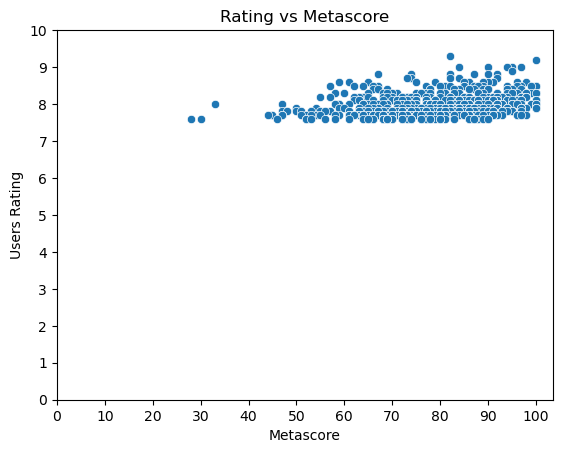

In [21]:
sns.scatterplot(x="metascore", y="rating", data=alldata_movies)
plt.title("Rating vs Metascore")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 11, 1))
plt.xlabel("Metascore")
plt.ylabel("Users Rating")
plt.show()

In [106]:
metacritic_reviews.head(1)

,publisher,author,rating,metacritic_id
0,Empire,Ian Nathan,100.0,movie/the-shawshank-redemption


In [22]:
top_publishers = metacritic_reviews \
    .groupby('publisher') \
    .agg({'rating': ['count']}) \
    .sort_values(by=[('rating', 'count')], ascending=False) \
    .head(20) \
    .reset_index() \
    ['publisher']

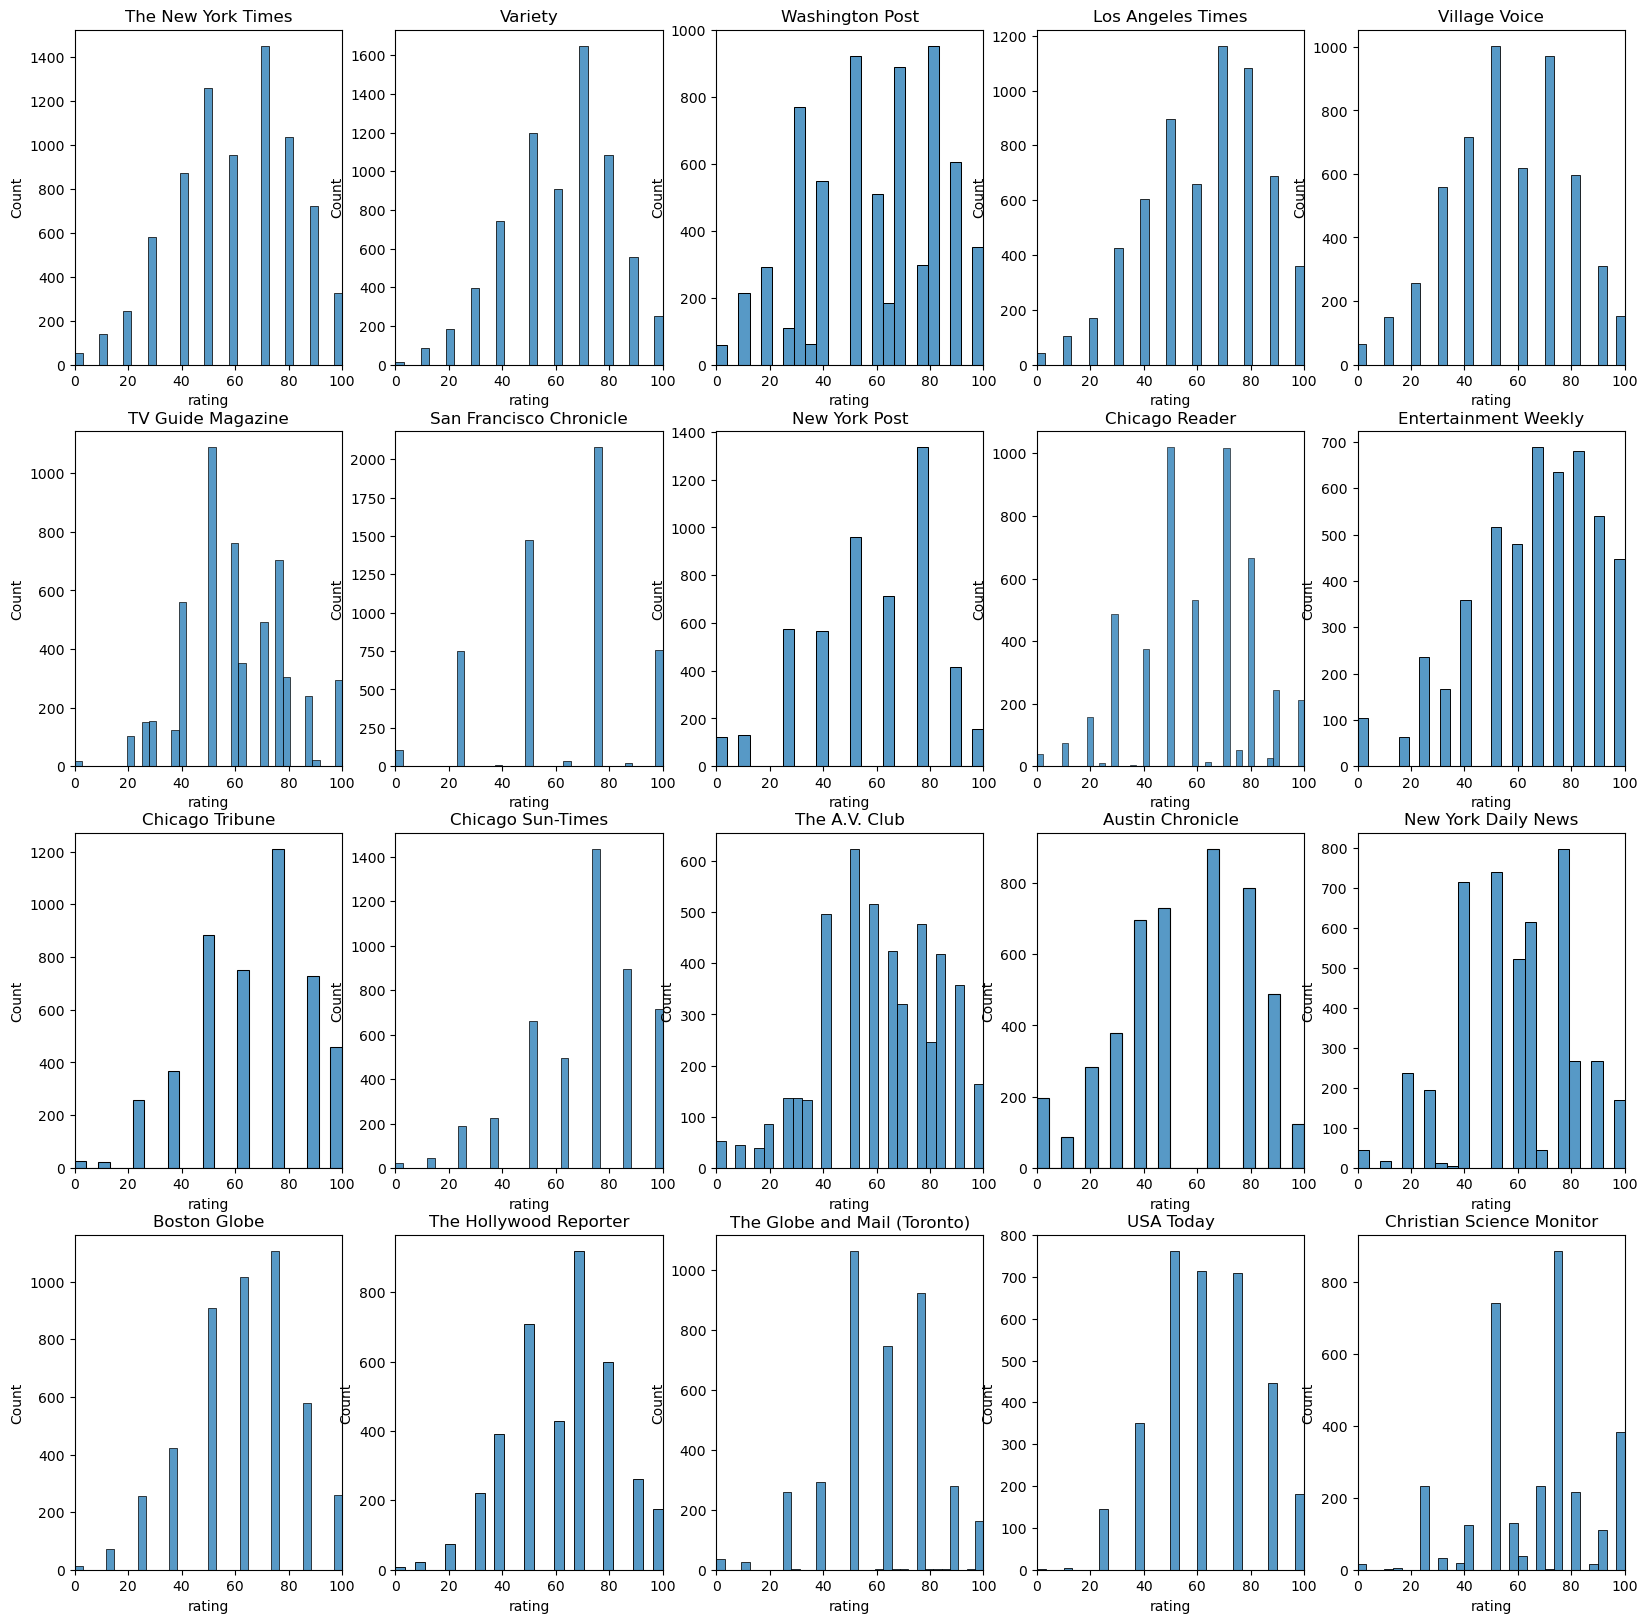

In [105]:
# create one subplot for each publisher
fig, axs = plt.subplots(len(top_publishers) // 5, 5, figsize=( 20, (len(top_publishers) // 5) * 5))

# plot the distribution of ratings for each publisher
for i, publisher in enumerate(top_publishers):
    ax = axs[i // 5][i % 5]
    ax.set_title(publisher)
    sns.histplot(metacritic_reviews.loc[metacritic_reviews['publisher'] == publisher]['rating'], ax=ax)
    ax.set_xlim(0, 100)

plt.show()


In [ ]:
merged_metacritic_reviews = metacritic_reviews.merge(cmu_movies.loc[(cmu_movies['metacritic_id'].isin(metacritic_reviews['metacritic_id'])) & ~(cmu_movies['metacritic_id'].isna()), ('metacritic_id', 'genres')], on='metacritic_id', how='left')

In [ ]:
# Assuming 'merged_metacritic_reviews' is your DataFrame
def extract_genres(row):
    try:
        genres_dict = ast.literal_eval(row['genres'])
        return list(genres_dict.values())
    except:
        return []
    

# Apply the function to extract genres
merged_metacritic_reviews['extracted_genres'] = merged_metacritic_reviews.apply(extract_genres, axis=1)

# Explode the DataFrame to have a separate row for each genre
exploded_df = merged_metacritic_reviews.explode('extracted_genres')

# Group by genre and calculate mean and count of ratings
grouped_df = exploded_df.groupby('extracted_genres').agg({'rating': ['mean', 'count']})

# Sort by the count of ratings and take the top 10
top_genres = grouped_df.sort_values(by=('rating', 'mean'), ascending=False).head(10)

In [ ]:
# select one occurence per movie
exploded_df.groupby('extracted_genres').agg({'rating': ['mean', 'count']}).sort_values(by=('rating', 'mean'), ascending=False)

In [ ]:
exploded_df.loc[exploded_df['extracted_genres'] == 'Film à clef']['metacritic_id'].unique()

In [ ]:
cmu_movies.loc[cmu_movies['metacritic_id'].isin(exploded_df.loc[exploded_df['extracted_genres'] == 'Film à clef']['metacritic_id'].unique())]

## 